Este projeto aplica o método de Transfer Learning com TensorFlow para classificar imagens de duas classes: gatos e cachorros. Utilizamos o modelo pré-treinado MobileNetV2 e um dataset disponibilizado pela Microsoft.

A arquitetura do modelo base é congelada e complementada com camadas densas para realizar a nova tarefa de classificação binária.


conexão com o drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/transfer_learning_imagens/kagglecatsanddogs_5340/PetImages


Cat  Dog


instalando dependencia

In [4]:
!pip install tensorflow

Filtrando imagens antes do treinamento

In [5]:
import os
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor, as_completed

base_path = '/content/drive/MyDrive/transfer_learning_imagens/kagglecatsanddogs_5340/PetImages'
categories = ['Cat', 'Dog']

def verificar_imagem(file_path):
    try:
        raw = tf.io.read_file(file_path)
        _ = tf.image.decode_jpeg(raw, channels=3)
    except Exception as e:
        print(f"Removendo: {file_path} -> erro: {e}")
        os.remove(file_path)

for category in categories:
    folder = os.path.join(base_path, category)
    print(f"Verificando imagens em paralelo: {folder}")

    file_paths = [os.path.join(folder, f) for f in os.listdir(folder)]

    with ThreadPoolExecutor(max_workers=8) as executor:  # 8 é um bom número para I/O
        futures = [executor.submit(verificar_imagem, fp) for fp in file_paths]
        for future in as_completed(futures):
            _ = future.result()  # Garante que exceções sejam tratadas


Verificando imagens em paralelo: /content/drive/MyDrive/transfer_learning_imagens/kagglecatsanddogs_5340/PetImages/Cat
Verificando imagens em paralelo: /content/drive/MyDrive/transfer_learning_imagens/kagglecatsanddogs_5340/PetImages/Dog


Separando imagens entre treino e verificação

In [6]:
import tensorflow as tf

data_dir = '/content/drive/MyDrive/transfer_learning_imagens/kagglecatsanddogs_5340/PetImages'
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 24824 files belonging to 2 classes.
Using 19860 files for training.
Found 24824 files belonging to 2 classes.
Using 4964 files for validation.


preparando rede

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Treinamento

Treinamento

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1354s 2s/step - accuracy: 0.6344 - loss: 0.6731 - val_accuracy: 0.7454 - val_loss: 0.5164
Epoch 2/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1265s 2s/step - accuracy: 0.7313 - loss: 0.5303 - val_accuracy: 0.7520 - val_loss: 0.5004
Epoch 3/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - accuracy: 0.7476 - loss: 0.5083 - val_accuracy: 0.7627 - val_loss: 0.4849
Epoch 4/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1178s 2s/step - accuracy: 0.7579 - loss: 0.4933 - val_accuracy: 0.7661 - val_loss: 0.4785
Epoch 5/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1188s 2s/step - accuracy: 0.7639 - loss: 0.4824 - val_accuracy: 0.7710 - val_loss: 0.4735
Epoch 6/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1217s 2s/step - accuracy: 0.7677 - loss: 0.4755 - val_accuracy: 0.7673 - val_loss: 0.4756
Epoch 7/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1203s 2s/step - accuracy: 0.7729 - loss: 0.4682 - val_accuracy: 0.7665 - val_loss: 0.4678
Epoch 8/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1236s 2s/step - accuracy: 0.7761 - loss: 0.4588 - 

verificação de aprendizado

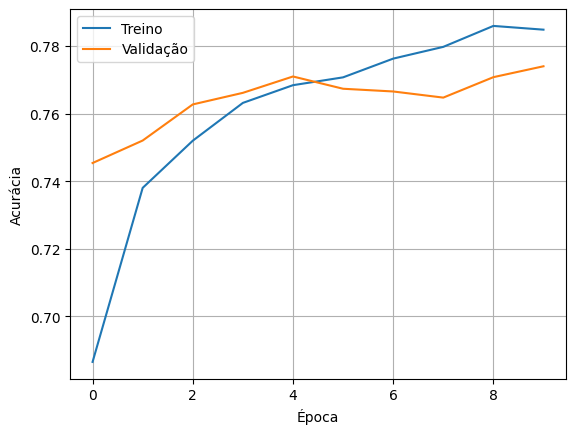

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


salvando modelo

In [14]:
model.save('/content/drive/MyDrive/transfer_learning_imagens/modelo_cats_vs_dogs.keras')


testando modelo com uma imagen da internet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


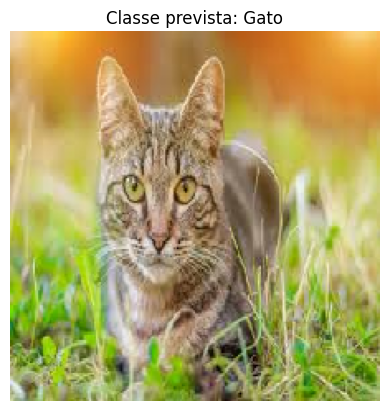

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Caminho da imagem de teste
img_path = '/content/images.jpg'

# Carrega e pré-processa a imagem
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array_expanded = np.expand_dims(img_array, axis=0)

# Faz a previsão
pred = model.predict(img_array_expanded)
classe = "Gato" if np.argmax(pred) == 0 else "Cachorro"

# Mostra a imagem com a classe prevista
plt.imshow(img)
plt.title(f'Classe prevista: {classe}')
plt.axis('off')
plt.show()
